# Numerical experiments "Towards Model-Agnostic Federated Learning over Networks" IV-B Synthetic Dataset - non-i.i.d. dataset

In [122]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.tree import DecisionTreeRegressor
from scipy.special import softmax
from sklearn.model_selection import train_test_split
import torch

# plt settings
plt.rcParams.update({'axes.spines.right': False,
                     'axes.spines.top': False})
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

In [123]:
save_npy = False

## Data

Here we create heterogeneous (non i.i.d.) datasets by sampling datapoints for a local dataset $\mathcal{D}^{(i)}$ from number $K$ of Gaussian distributions.

The similarity $A_{i,i'}  \in [0,1]$ between nodes $i$ and $i'$ is determined by counting the number of similar datapoints they posses (i.e. the number of datapoints sampled from the same distribution $k=1,..,K$).

We create such synthetic heterogeneous local datasets with number of distributions set $K=3$ and total number of nodes $|\mathcal{V}|=150$. Each local dataset consist of training subset of size $m_i=10$ and validation subset of size $m^{(val)}_i=100$. We tested datasets with varying dimensionality $d  \in \{2,10,20,50,100 \}$ of the feature vector  $\mathbf{x}^{(i,r)}  \in  \mathbb{R}^{d}$. 

In [75]:
def get_data_noniid(n_distr, n_ds, m_train, n_features, noise_scale=1.0):
    
    """
    
    Function to create non i.i.d. noisy Gaussian regression datasets. 
    For each node we create training (size = n_samples) and validation (size = 100) ds.
    
    :param n_distr:      number of distributions K
    :param n_ds:         number of local datasets to compute n.o. nodes (n_nodes=n_distr*n_ds)
    :param n_samples:    number of samples in a local dataset
    :param n_features:   number of features of a datapoint
    :param noise_scale:  scale of normal distribution used to generate data noise
    
    :out ds_train:       list of (n_distr*n_ds) local train datasets (X,y) of sample size n_samples
    :out ds_val:         list of (n_distr*n_ds) local validation datasets of sample size 100
    :out ratios:         list of (n_nodes, n_distr), prop'n of datapoints to sample from distribution k

    """
    
    # Lists to store and return outputs
    n_nodes, m_val   = n_distr*n_ds, 100
    ds_train, ds_val = [], []
    ratios           = np.zeros((n_nodes, n_distr))
    true_weights     = np.zeros((n_distr, n_features))

    # Sample true weight vector for distr i
    for i in range(n_distr): true_weights[i] = np.random.normal(0, 1, size=(n_features))
    for n in range(n_nodes):
        # prop'n of datapoints of a certain Gaussian distribution
        ratio = softmax(np.random.normal(size=n_distr))
        X_, y_ = [], []
        X_val_, y_val_ = [], []
        
        for i in range(n_distr):
            w = true_weights[i].reshape(-1,1)
            s, s_val = int(np.ceil(ratio[i]*(m_train+1))), int(np.ceil(ratio[i]*(m_val+1)))
            
            X     = np.random.normal(0, 1.0, size=(s, n_features))
            X_val = np.random.normal(0, 1.0, size=(s_val, n_features))
            
            y     = X@w + np.random.normal(0, noise_scale, size=(s, 1))
            y_val = X_val@w + np.random.normal(0, noise_scale, size=(s_val, 1))

            X_.append(X), y_.append(y)
            X_val_.append(X_val), y_val_.append(y_val)

         
        X_, y_ = np.concatenate(X_), np.concatenate(y_)
        X_val_, y_val_ = np.concatenate(X_val_), np.concatenate(y_val_)

        ratios[n] =  ratio

        idx = np.random.choice(X_.shape[0], m_train, replace=False) 
        ds_train.append( (X_[idx], y_[idx]) )

        idx = np.random.choice(X_val_.shape[0], m_val, replace=False) 
        ds_val.append( (X_val_[idx], y_val_[idx]) )

    return ds_train, ds_val, ratios
    

In [76]:
def get_data_gauss(n_nodes, m_pub, n_features):

    """

    Create Gaussian dataset for all nodes.

    Args:
    : n_nodes    : scalar, number of nodes
    : m_pub      : scalar, number of samples in shared public dataset
    : n_features : scalar, number of features of a datapoint
    Out:
    : data_test  : array of shape (n_nodes, m_pub, n_features), feature matrix

    """

    ds_pub = np.random.normal(0, 1.0, size=(n_nodes, m_pub, n_features))

    return ds_pub

## Graph

In [77]:
def build_graph(ds_train, ds_val, models):

    """

    Function to generate graph.

    :param ds_train:       list of (n_distr*n_ds) local train datasets of sample size n_samples
    :param ds_val:         list of (n_distr*n_ds) local validation datasets of sample size 100
    :param models:         list of (n_distr*n_ds) local models

    :out G:                list of (n_distr*n_ds) python dictionaries (graph nodes) where each dict (node)  contain local train/ val datasets, model

    """
    G = []
    for ds_t, ds_v, model in zip(ds_train, ds_val, models):
        G.append({"ds_train": ds_t, "ds_val": ds_v, "model": model}) 
        
    return G

def build_edges_noniid(ratios):
    # (n_nodes, n_distr)
    nn, n_distr = ratios.shape[0], ratios.shape[1]
    A = np.zeros((nn, nn))
    rows, cols = A.shape

    for i in range(rows):
        for j in range(cols):
            if i==j:
                A[i,j] = 0
            else:
                A[i,j] = sum([min(ratios[i,d], ratios[j,d]) for d in range(n_distr)])
    return A

## Training loop

In [78]:
def train(G, A, ds_pub, iters=1000, reg=0.01): 
    
    """
    Args:
    
    : G              : list of dicts [dict keys are: model, ds_train, ds_val], represents graph with n_nodes.
    : A              : array of size (n_nodes,n_nodes), adjacency matrix
    : ds_pub         : array of size (n_nodes, m_pub), shared public dataset
    : iters          : scalar, number of iterations or updates of the local model
    : reg            : scalar, scaling factor for GTV term

    Out:

    : mse_train      : array of size (n_nodes, iters), MSE on local training set
    : mse_val        : array of size (n_nodes, iters), MSE on local validation set

    """
    
    n_nodes     = len(G)                             # number of nodes in a graph
    m_pub       = ds_pub.shape[1]                    # sample size of the shared public ds
    nodes_preds = np.zeros((n_nodes, m_pub))         # init predictions on a shared ds

    # MSE on validation subset
    mse_train      = np.zeros((n_nodes, iters))
    mse_val        = np.zeros((n_nodes, iters))

    # Training loop
    for i in range(iters):
        for n in range(n_nodes):
            # get node data
            ds_train  = G[n]["ds_train"]
            ds_val    = G[n]["ds_val"]
            model     = G[n]["model"]

            # model predictions
            pred_train  = model.predict(ds_train[0])
            pred_val    = model.predict(ds_val[0])

            mse_train[n,i]      = np.mean((ds_train[1] - pred_train.reshape(-1,1))**2)
            mse_val[n,i]        = np.mean((ds_val[1] - pred_val.reshape(-1,1))**2)

            # Update local models
            _ = model.update(ds_train, ds_pub, nodes_preds, A[n], reg) 
            
        # Update predictions on a shared public set 
        nodes_preds = np.zeros((n_nodes, m_pub))
        for n in range(n_nodes):
            model          = G[n]["model"]
            nodes_preds[n] = model.predict(ds_pub[n]).reshape(-1,)

    return mse_train, mse_val
        

## FedRelax for Parametric Models - Pytorch linear regressor

In [79]:
class Optimize(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        
    # Model prediction with tracking gradients
    def forward(self, x):
        if type(x) != torch.Tensor:
            x = torch.FloatTensor(x)
            
        pred = self.model(x)
        return pred
    
    # Model prediction without tracking gradients
    def predict(self, x):
        if type(x) != torch.Tensor:
            x = torch.FloatTensor(x)
            
        with torch.no_grad():
            pred = self.model(x)
        return pred.detach().numpy() 

    def update(self, ds_train, ds_pub, nodes_preds, A, regularizer_term):
        
        """
        Function to implement step (19) - min local loss + regularization term
        
        nn - number of nodes
        m_pub - sample size of shared public data; for convenience it is the same for all nodes

        Args:
        : ds_train         : list of (n_nodes) local train datasets of sample size n_samples
        : ds_pub           : array of size (n_nodes, m_pub, n_features), public dataset shared with other nodes
        : nodes_preds      : predictions on ds_pub by the local model on the node, array of size (n_nodes, m_pub)
        : A                : row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        : regularizer_term : lambda, float number
        
        """
        # Local training set
        X, y = ds_train[0], ds_train[1]

        # Convert numpy arrays to torch tensors
        X, y = torch.FloatTensor(X), torch.FloatTensor(y)
        ds_pub = torch.FloatTensor(ds_pub) 
        
        A = torch.from_numpy(A).float().reshape(-1,1)   # shape (n_nodes,1)
        nodes_preds = torch.from_numpy(nodes_preds).float() # shape (n_nodes,m_pub)

        # Get predictions for local and shared public ds
        pred = self.model(X)
        pred_pub = self.model(ds_pub)  # out shape (n_nodes,m_pub,1)
        
        # Set all gradient values to zeros
        self.model.zero_grad()  
        
        # Compute loss
        loss_local = self.criterion(y, pred)
        loss_GTV = torch.mean( ((torch.squeeze(pred_pub) - nodes_preds)**2).T@A )
        loss = loss_local + regularizer_term*loss_GTV
        
        # Backpropagate the gradients
        loss.backward()

        # Update parameters of the model using the chosen optimizer
        self.optimizer.step()

        return loss.item()

class Linreg_Torch(Optimize):
    def __init__(self, n_features, lr=0.001, bias=True):
        Optimize.__init__(self)
        
        # Define model
        if bias==False:
            self.model = torch.nn.Linear(n_features, 1, bias=False)
        else:
            self.model = torch.nn.Linear(n_features, 1)
            
        # Define Loss and Optimizer
        self.criterion = torch.nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=lr)


### Configuration

We generate $n = 150$ local datasets as described above. 

In [8]:
def experiment (reg_term, n_features, noise, iters):
    np.random.seed(0)
    n_distr, n_ds, n_samples = 3, 50, 10
    m_pub          = 100
    n_nodes        = n_distr * n_ds
    repeat_times   = 5

    # MSE on validation subset
    mse_train_      = np.zeros((repeat_times, n_nodes, iters))
    mse_val_        = np.zeros((repeat_times, n_nodes, iters))

    for i in range(repeat_times):
        
        # Create linear pytorch models
        models = [Linreg_Torch(n_features, lr=0.01, bias=False) for i in range(n_distr*n_ds)]
    
        # Create a dataset
        ds_train, ds_val, ratios = get_data_noniid(n_distr, n_ds, n_samples, n_features, noise)
        # shared public datasetpublic is sampled from Gaussian distr ~N(0,1) for each node
        # array of shape (n_nodes, m_pub, n_features)
        ds_pub = get_data_gauss(n_distr*n_ds, m_pub, n_features)

        # Build a graph with nodes {model, dataset local, dataset pub}
        G = build_graph(ds_train, ds_val, models)
        A = build_edges_noniid(ratios)
        mse_train, mse_val = train(G, A, ds_pub, iters, reg_term)

        mse_train_[i]      = mse_train
        mse_val_[i]        = mse_val

    return np.mean(mse_train_, axis=(0,1)), np.mean(mse_val_, axis=(0,1))


### Different d/m ratio

In [124]:
%%time
# vary number of features, m_i=10 fixed
# d = 2, 10, 20, 50, 100 ~> d/m = 0.2, 1, 2, 5, 10 
d = [2, 10, 20, 50, 100]
reg   = [0, 0.01, 0.05]
noise = 0
iters = 500

if save_npy:
    mse_train      = np.zeros((len(reg),len(d), iters))
    mse_val        = np.zeros((len(reg),len(d), iters))
    
    for i, reg_term in enumerate(reg):  
        out = Parallel(n_jobs=-1)(delayed(experiment)(reg_term, n_features, noise, iters) for n_features in d)
        
        for j in range(len(d)):
            mse_train[i,j]      = out[j][0]
            mse_val[i,j]        = out[j][1]
else:
    mse_train, mse_val = np.load("Pytorch_noniid_mse_train.npy"), np.load("Pytorch_noniid_mse_val.npy")

CPU times: user 869 μs, sys: 2.23 ms, total: 3.1 ms
Wall time: 3.34 ms


**Model performance: MSE on training set**

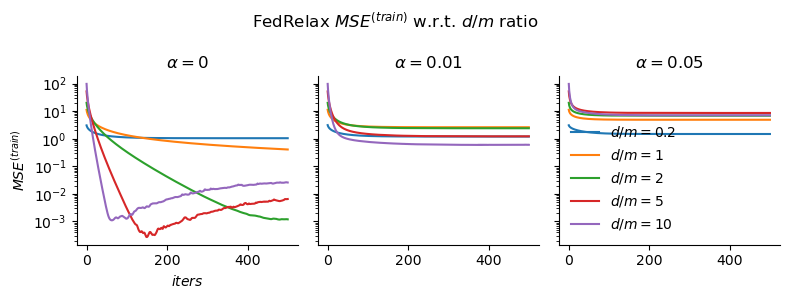

In [10]:
labels = ['$d/m = 0.2$', '$d/m = 1$', '$d/m = 2$', '$d/m = 5$', '$d/m = 10$']
titles = [r'$\alpha=0$', r'$\alpha=0.01$', r'$\alpha=0.05$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(8,3))

for ax, mse, title in zip(axs, mse_train, titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel (r'$MSE^{(train)}$')
axs[0].set_xlabel ('$iters$')

plt.legend(frameon=False)
plt.yscale('log')
fig.suptitle('FedRelax $MSE^{(train)}$ w.r.t. $d/m$ ratio')
fig.tight_layout()
# plt.savefig("Pytorch_reg_val_dm.png")
plt.show()

**Model performance: MSE on validation set**

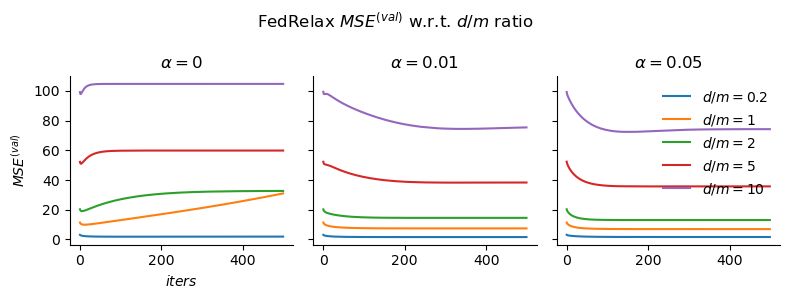

In [11]:
labels = ['$d/m = 0.2$', '$d/m = 1$', '$d/m = 2$', '$d/m = 5$', '$d/m = 10$']
titles = [r'$\alpha=0$', r'$\alpha=0.01$', r'$\alpha=0.05$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(8,3))

for ax, mse, title in zip(axs, mse_val, titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel (r'$MSE^{(val)}$')
axs[0].set_xlabel ('$iters$')

plt.legend(frameon=False)
#plt.yscale('log')
fig.suptitle('FedRelax $MSE^{(val)}$ w.r.t. $d/m$ ratio')
fig.tight_layout()
# plt.savefig("Pytorch_reg_val_dm.png")
plt.show()

### Different noise levels

In [125]:
%%time

n_features = 10
reg   = [0, 0.01, 0.05]
noise_vals = [0, 1, 5]
iters = 500

if save_npy:
    mse_train_noise = np.zeros((len(reg),len(noise_vals), iters))
    mse_val_noise = np.zeros((len(reg),len(noise_vals), iters))
    
    for i, reg_term in enumerate(reg):  
        out = Parallel(n_jobs=-1)(delayed(experiment)(reg_term, n_features, noise, iters) for noise in noise_vals)
        
        for j in range(len(noise_vals)):
            mse_train_noise[i,j]      = out[j][0]
            mse_val_noise[i,j]        = out[j][1]
else:
    mse_train_noise, mse_val_noise = np.load("Pytorch_noniid_mse_train_noise.npy"), np.load("Pytorch_noniid_mse_val_noise.npy")
    

CPU times: user 1.19 ms, sys: 2.11 ms, total: 3.3 ms
Wall time: 3.4 ms


In [59]:
if save_npy:
    np.save("Pytorch_noniid_mse_train", mse_train)
    np.save("Pytorch_noniid_mse_val", mse_val)
    np.save("Pytorch_noniid_mse_train_noise", mse_train_noise)
    np.save("Pytorch_noniid_mse_val_noise", mse_val_noise)

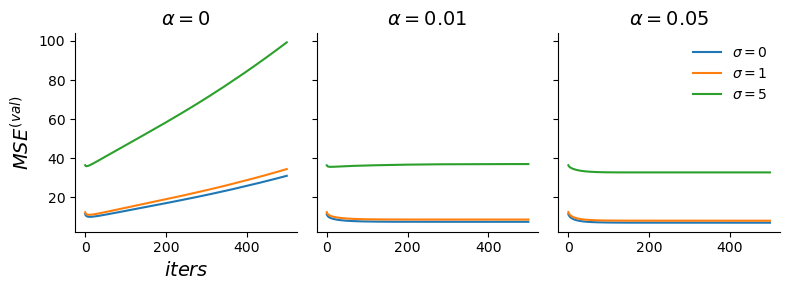

In [60]:
labels = [r'$\sigma = 0$', r'$\sigma = 1$', r'$\sigma = 5$']
titles = [r'$\alpha=0$', r'$\alpha=0.01$', r'$\alpha=0.05$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(8,3))

for ax, mse, title in zip(axs, mse_val_noise, titles):
    for i in range(len(noise_vals)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel (r'$MSE^{(val)}$')
axs[0].set_xlabel ('$iters$')

plt.legend(frameon=False)
#fig.suptitle('FedRelax $MSE^{(val)}$ w.r.t. noise level, d/m=1')
fig.tight_layout()
#plt.savefig("Pytorch_reg_err_noise.png")
plt.show()

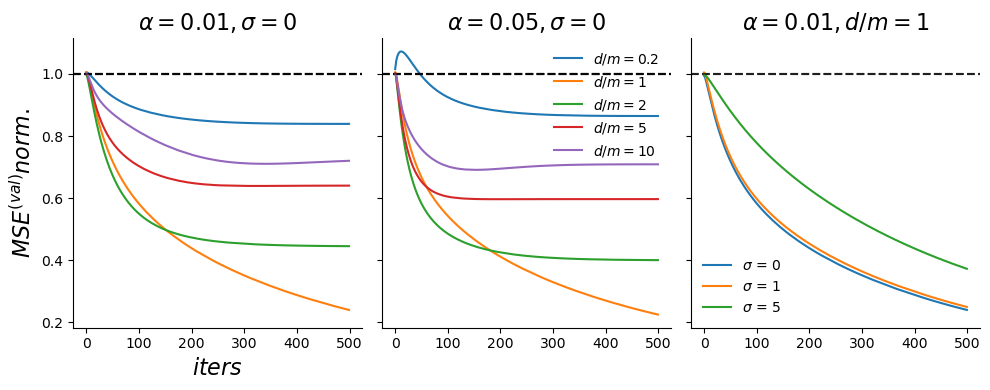

In [127]:
labels = ['$d/m = 0.2$', '$d/m = 1$', '$d/m = 2$', '$d/m = 5$', '$d/m = 10$']
labels_noise = [r'$\sigma$ = 0', r'$\sigma$ = 1', r'$\sigma$ = 5']
titles = [r'$\alpha=0.01, \sigma=0$', r'$\alpha=0.05, \sigma=0$']

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10,4))

for ax, mse, title in zip(axs, mse_val[1:], titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i] / mse_val[0][i], label=labels[i])
        ax.axhline(y=1, ls='--', c='k', alpha=0.5)
        ax.set_title(title)

for i in range(len(noise_vals)):
    axs[2].plot(np.arange(len(mse_val_noise[1][i])), mse_val_noise[1][i] / mse_val_noise[0][i], label=labels_noise[i])
    axs[2].axhline(y=1, ls='--', c='k', alpha=0.5)
axs[2].set_title(r'$\alpha=0.01, d/m=1$')

axs[0].set_ylabel ('$MSE^{(val)} norm.$')
axs[0].set_xlabel ('$iters$')

axs[1].legend(frameon=False)
plt.legend(frameon=False)
fig.tight_layout()
plt.savefig("Pytorch_noniid_val.png")
plt.show()

## FedRelax for Non-Parametric Models - SKlearn DT regressor

As model we use decision tree regressor implemented with python library scikit-learn. We implement line 4 of Algorithm 1, computing regularized local loss as defined in Eq.(11), by constructing augmented local dataset. Augmented dataset is the local dataset $\mathcal{D}^{(i)}$ augmented by the data points $(\mathbf{x},\widehat{h}^{(i')}((\mathbf{x}))$, $\mathbf{x} \in \mathcal{P}^{(i')}$ for all nodes $i' \sim \mathcal{N}^{(i)}$.
We initialize hypothesis $\widehat{h}^{(i)}$ by fitting decision tree regressor to the training set of the client $\mathcal{D}^{(i)}$.
To pass regularization parameter $\alpha$ in Eq.(11) to the training function, we use provided function argument called sample weight (see documentation https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.fit).

We run experiment for different values of data dimensionality $d = \{2,10,20,50,100 \}$.

In [92]:
class Data_augmentation():  
    @staticmethod
    def data_aug(ds_train, ds_pub, nodes_preds, A, regularizer_term):
        
        """
        nn - number of nodes
        m' - sample size of shared public data
        
        :param ds_train:         list of (n_distr*n_ds) local train datasets of sample size n_samples
        :param ds_pub:           array of size(n_nodes, m_pub, n_features), shared public dataset
        :param nodes_preds:      predictions for ds_pub of all nodes, array of size (n_nodes, m_pub)
        :param A:                row of a symmetric matrix A (weights of edges), array of size (nn,); A_ii=0 (zero diagonal)
        :param regularizer_term: lambda, float number

        :out X_aug: stacked features X (local train ds), ds_pub (public datasets)
        :out y_aug: stacked labels y (local train ds), nodes_preds (predictions for ds_pub at each node)
        :out sample_weight: sample_weight - 1 for (X, y) and regularizer_term*A for other samples.
        
        """
        
        X, y = ds_train[0], ds_train[1].reshape(-1,)
        
        # Construct augmented dataset
        m = len(y)
        nn, m_pub = ds_pub.shape[0], ds_pub.shape[1]
        
        X_aug = np.concatenate((X, ds_pub.reshape(nn*m_pub, -1)), axis=0)
        y_aug = np.concatenate((y, nodes_preds.reshape(-1,)), axis=0)
        
        # Format edges' weights A and compute sample weight
        A_repeat = np.repeat(A, m_pub, axis=0)
        sample_weight = np.concatenate((np.ones((m,)), np.ones((nn*m_pub,))*regularizer_term*A_repeat))   

        return X_aug, y_aug.reshape(-1,1), sample_weight
        

In [93]:
class DTReg(DecisionTreeRegressor, Data_augmentation):
    def __init__(self, **kwargs):
        DecisionTreeRegressor.__init__(self, **kwargs)

    def update(self, ds_local, ds_pub,  pred_pub, A, regularizer_term):
        
        if regularizer_term == 0: 
            self.fit(ds_local[0], ds_local[1])
        else:
            X_aug, y_aug, sample_weight = self.data_aug(ds_local, ds_pub,  pred_pub, A, regularizer_term)
            # to keep learnt info from resettingpublic
            X_learnt = np.random.normal(0, 1.0, size=(100, X_aug.shape[1]))
            y_learnt = self.predict(X_learnt)
    
            X_stack = np.concatenate((X_aug, X_learnt), axis=0)
            y_stack = np.concatenate((y_aug.reshape(-1,), y_learnt), axis=0)
            sample_weight_stack = np.concatenate((sample_weight, np.ones((100,))))
                               
            self.fit(X_stack, y_stack, sample_weight=sample_weight_stack)

In [94]:
def experiment (reg_term, n_features, noise, iters):
    np.random.seed(0)
    n_distr, n_ds, n_samples = 3, 50, 10
    m_pub          = 100
    n_nodes        = n_distr * n_ds
    repeat_times   = 5

    # MSE on validation subset
    mse_train_      = np.zeros((repeat_times, n_nodes, iters))
    mse_val_        = np.zeros((repeat_times, n_nodes, iters))

    for i in range(repeat_times):
    
        # Create a dataset
        ds_train, ds_val, ratios = get_data_noniid(n_distr, n_ds, n_samples, n_features, noise)
        # shared public dataset is sampled from Gaussian distr ~N(0,1) for each node
        # array of shape (n_nodes, m_pub, n_features)
        ds_pub = get_data_gauss(n_distr*n_ds, m_pub, n_features)

        # Create linear pytorch models
        models = [DTReg(max_depth=5).fit(ds_train[i][0], ds_train[i][1]) for i in range(n_distr*n_ds)]
        
        # Build a graph with nodes {model, dataset local, dataset public}
        G = build_graph(ds_train, ds_val, models)
        A = build_edges_noniid(ratios)
        mse_train, mse_val = train(G, A, ds_pub, iters, reg_term)

        mse_train_[i]      = mse_train
        mse_val_[i]        = mse_val

    return np.mean(mse_train_, axis=(0,1)), np.mean(mse_val_, axis=(0,1))


In [128]:
%%time

# d/m = 0.2, 1, 2, 5, 10 ~> d = 2, 10, 20, 50, 100
d = [2, 10, 20, 50, 100]
reg   = [0, 0.001, 1]
noise = 0
iters = 5

if save_npy:
    mse_train = np.zeros((len(reg),len(d), iters))
    mse_val = np.zeros((len(reg),len(d), iters))
    
    for i, reg_term in enumerate(reg):  
        out = Parallel(n_jobs=-1)(delayed(experiment)(reg_term, n_features, noise, iters) for n_features in d)
        
        for j in range(len(d)):
            mse_train[i,j]      = out[j][0]
            mse_val[i,j]        = out[j][1]
else:
     mse_train, mse_val = np.load("DTreg_noniid_mse_train.npy"), np.load("DTreg_noniid_mse_val.npy")

CPU times: user 1.46 ms, sys: 1.93 ms, total: 3.39 ms
Wall time: 11.9 ms


**Model performance: MSE on validation set**

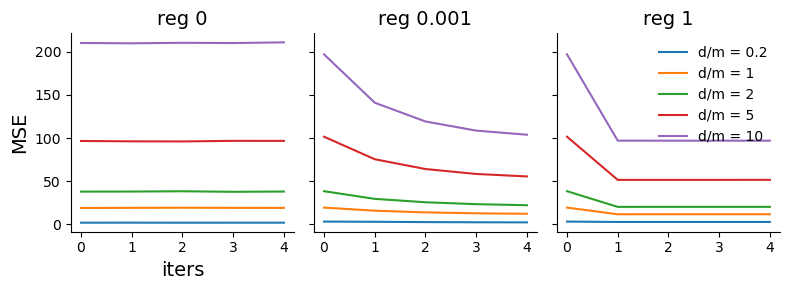

In [98]:
labels = ['d/m = 0.2', 'd/m = 1', 'd/m = 2', 'd/m = 5', 'd/m = 10']
titles = ['reg 0', 'reg 0.001', 'reg 1']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(8,3))

for ax, mse, title in zip(axs, mse_val, titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel ('MSE')
axs[0].set_xlabel ('iters')

plt.legend(frameon=False)
#plt.yscale('log')
#fig.suptitle('Algorithm 2 MSE w.r.t. d/m ratio')
fig.tight_layout()
# plt.savefig("DTreg_train.png")
plt.show()

### Different noise levels

In [129]:
%%time

n_features = 10
reg   = [0, 0.001, 1]
noise_vals = [0, 1, 5]
iters = 5

if save_npy:
    mse_train_noise = np.zeros((len(reg),len(noise_vals), iters))
    mse_val_noise = np.zeros((len(reg),len(noise_vals), iters))
    
    for i, reg_term in enumerate(reg):  
        out = Parallel(n_jobs=-1)(delayed(experiment)(reg_term, n_features, noise, iters) for noise in noise_vals)
        
        for j in range(len(noise_vals)):
            mse_train_noise[i,j]      = out[j][0]
            mse_val_noise[i,j]        = out[j][1]
else:
    mse_train_noise, mse_val_noise = np.load("DTreg_noniid_mse_train_noise.npy"), np.load("DTreg_noniid_mse_val_noise.npy")
    

CPU times: user 1.39 ms, sys: 3.3 ms, total: 4.69 ms
Wall time: 11.4 ms


In [99]:
if save_npy:
    np.save("DTreg_noniid_mse_train", mse_train)
    np.save("DTreg_noniid_mse_val", mse_val)
    np.save("DTreg_noniid_mse_train_noise", mse_train_noise)
    np.save("DTreg_noniid_mse_val_noise", mse_val_noise)

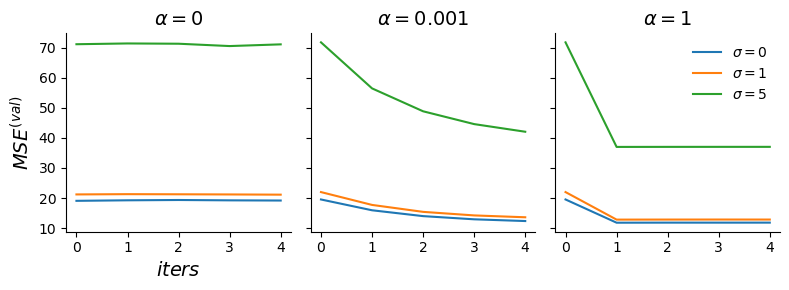

In [100]:
labels = [r'$\sigma = 0$', r'$\sigma = 1$', r'$\sigma = 5$']
titles = [r'$\alpha=0$', r'$\alpha=0.001$', r'$\alpha=1$']

fig, axs = plt.subplots(1, len(reg), sharey=True, figsize=(8,3))

for ax, mse, title in zip(axs, mse_val_noise, titles):
    for i in range(len(noise_vals)):
        ax.plot(np.arange(len(mse[i])), mse[i], label=labels[i])
    ax.set_title(title)

axs[0].set_ylabel (r'$MSE^{(val)}$')
axs[0].set_xlabel ('$iters$')

plt.legend(frameon=False)
#fig.suptitle('Algorithm 2 MSE w.r.t. noise level, d/m=1')
fig.tight_layout()
#plt.savefig("DTreg_clustered_MSEnorm_noise.png")
plt.show()

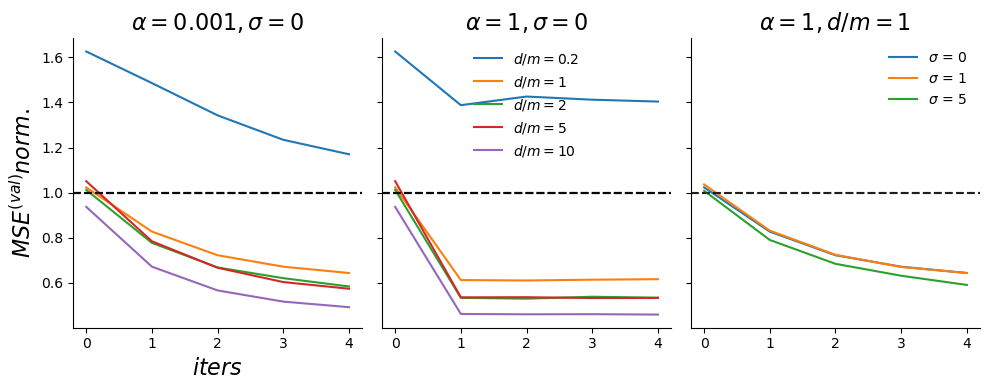

In [130]:
labels = ['$d/m = 0.2$', '$d/m = 1$', '$d/m = 2$', '$d/m = 5$', '$d/m = 10$']
labels_noise = [r'$\sigma$ = 0', r'$\sigma$ = 1', r'$\sigma$ = 5']
titles = [r'$\alpha=0.001, \sigma=0$', r'$\alpha=1, \sigma=0$']

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10,4))

for ax, mse, title in zip(axs, mse_val[1:], titles):
    for i in range(len(d)):
        ax.plot(np.arange(len(mse[i])), mse[i] / mse_val[0][i], label=labels[i])
        ax.axhline(y=1, ls='--', c='k', alpha=0.5)
        ax.set_title(title)

for i in range(len(noise_vals)):
    axs[2].plot(np.arange(len(mse_val_noise[1][i])), mse_val_noise[1][i] / mse_val_noise[0][i], label=labels_noise[i])
    axs[2].axhline(y=1, ls='--', c='k', alpha=0.5)
axs[2].set_title(r'$\alpha=1, d/m=1$')

axs[0].set_ylabel ('$MSE^{(val)} norm.$')
axs[0].set_xlabel ('$iters$')

axs[1].legend(frameon=False)
plt.legend(frameon=False)
#fig.suptitle('Algorithm 2 MSE w.r.t. d/m ratio')
fig.tight_layout()
plt.savefig("DTreg_noniid_val.png")
plt.show()